# Libraries

In [1]:
import pandas as pd
import numpy as np

# Merge Scooters and Weather

## Scooters

In [ ]:
df_ = pd.read_csv("../data/tidy-scooters.csv", parse_dates = ['Start', 'End'])

In [ ]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535807 entries, 0 to 535806
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   TripID          535807 non-null  object        
 1   Start           535807 non-null  datetime64[ns]
 2   End             535807 non-null  datetime64[ns]
 3   Duration        535807 non-null  int64         
 4   Distance        535807 non-null  int64         
 5   StartLatitude   535807 non-null  float64       
 6   StartLongitude  535807 non-null  float64       
 7   EndLatitude     535807 non-null  float64       
 8   EndLongitude    535807 non-null  float64       
 9   DayOfWeek       535807 non-null  int64         
 10  HourNum         535807 non-null  int64         
 11  WeekOfYear      535807 non-null  int64         
 12  Covid           535807 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(6), object(1)
memory usage: 53.1+ MB


### Hourly Resampling

In [ ]:
df = df_.set_index("Start").resample('1H').agg({"TripID":'nunique',
                                                      "Duration":'mean',
                                                      "Distance":'mean'})

In [ ]:
df.isna().sum()

TripID         0
Duration    4228
Distance    4228
dtype: int64

In [ ]:
df.head()

,TripID,Duration,Distance
Start,,,
2018-08-09 10:00:00,12,25.750000,2571.750000
2018-08-09 11:00:00,29,11.068966,1776.620690
2018-08-09 12:00:00,34,16.235294,2767.882353
2018-08-09 13:00:00,38,19.763158,3450.026316
2018-08-09 14:00:00,12,12.666667,2001.833333


The resampling operation create new rows: for values = 0 in TripsCount, the operation cannot
calculate the mean for these. So, we decide to fill NaN values with 0

In [ ]:
for col in df.columns:
    df[col] = df[col].fillna(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16775 entries, 2018-08-09 10:00:00 to 2020-07-08 08:00:00
Freq: H
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TripID    16775 non-null  int64  
 1   Duration  16775 non-null  float64
 2   Distance  16775 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.1 MB


In [ ]:
scooters = df.reset_index()

We add two new columns respectively for the "day of the week" and for the "hour number"

In [ ]:
scooters['WeekOfYear'] = scooters['Start'].dt.isocalendar().week
scooters["DayOfWeek"] = scooters["Start"].dt.dayofweek
scooters["HourNum"] = scooters["Start"].dt.hour
scooters['Covid'] = np.where(scooters['Start'] >= '2020-03-21 00:00:00', 1, 0)

In [ ]:
scooters.rename(columns = {'TripID':'Count'}, inplace=True)
scooters.rename(columns = {'Start':'Date'}, inplace=True)

## Weather

In [ ]:
df__ = pd.read_csv('../data/hourly-weather.csv', parse_dates= ['Date'])

In [ ]:
df__.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33624 entries, 0 to 33623
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           33624 non-null  datetime64[ns]
 1   Temperature    23831 non-null  float64       
 2   Precipitation  33624 non-null  float64       
 3   Humidity       33624 non-null  float64       
 4   Visibility     33624 non-null  float64       
 5   WindSpeed      33624 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.5 MB


### Check Dates Compatibilities

In [ ]:
scooters.head(1)

,Date,Count,Duration,Distance,WeekOfYear,DayOfWeek,HourNum,Covid
0,2018-08-09 10:00:00,12,25.75,2571.75,32,3,10,0


In [ ]:
scooters.tail(1)

,Date,Count,Duration,Distance,WeekOfYear,DayOfWeek,HourNum,Covid
16774,2020-07-08 08:00:00,4,33.25,2285.5,28,2,8,1


We will have to select this date range for merging the datsets

In [ ]:
c1 = df__['Date'] >= "2018-08-09 10:00:00"
c2 = df__['Date'] <= "2020-07-08 08:00:00"
weather = df__[c1 & c2]

Now we check for missing values!

<AxesSubplot:>

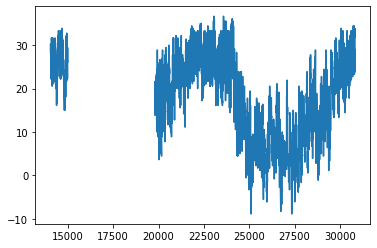

In [ ]:
weather['Temperature'].plot()

In [ ]:
weather.loc[weather.Temperature.isnull()]

,Date,Temperature,Precipitation,Humidity,Visibility,WindSpeed
14996,2018-09-17 20:00:00,NaN,0.0,79.0,10.00,8.045
14997,2018-09-17 21:00:00,NaN,0.0,82.0,10.00,11.263
14998,2018-09-17 22:00:00,NaN,0.0,82.0,10.00,8.045
14999,2018-09-17 23:00:00,NaN,0.0,79.0,10.00,4.827
15000,2018-09-18 00:00:00,NaN,0.0,79.0,10.00,8.045
...,...,...,...,...,...,...
19790,2019-04-05 14:00:00,NaN,0.0,67.0,10.00,12.872
19791,2019-04-05 15:00:00,NaN,0.0,67.0,10.00,8.045
19792,2019-04-05 16:00:00,NaN,0.0,67.0,9.97,9.654
19793,2019-04-05 17:00:00,NaN,0.0,70.0,10.00,9.654


There are still some structurally missing values in the dataset, which we want to select and drop.

In [ ]:
weather = weather[weather['Date'] > "2019-04-05 18:00:00"]

In [ ]:
scooters = scooters[scooters['Date'] > "2019-04-05 18:00:00"]

<AxesSubplot:>

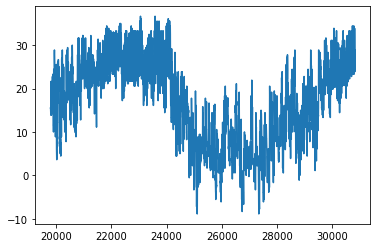

In [ ]:
weather['Temperature'].plot()

## Merge & Save Dataset

In [ ]:
scooters.set_index('Date', inplace = True)
weather.set_index('Date', inplace = True)

In [ ]:
scooters.head()

,Count,Duration,Distance,WeekOfYear,DayOfWeek,HourNum,Covid
Date,,,,,,,
2019-04-05 19:00:00,65,15.492308,1725.384615,14,4,19,0
2019-04-05 20:00:00,30,17.266667,2182.066667,14,4,20,0
2019-04-05 21:00:00,19,18.105263,1992.000000,14,4,21,0
2019-04-05 22:00:00,17,17.941176,2296.117647,14,4,22,0
2019-04-05 23:00:00,11,21.636364,1973.818182,14,4,23,0


In [ ]:
weather.head()

,Temperature,Precipitation,Humidity,Visibility,WindSpeed
Date,,,,,
2019-04-05 19:00:00,15.555556,0.0,72.0,9.97,2.413500
2019-04-05 20:00:00,15.555556,0.0,72.0,10.00,0.000000
2019-04-05 21:00:00,15.555556,0.0,72.0,10.00,4.827000
2019-04-05 22:00:00,15.370370,0.0,73.0,9.98,5.899667
2019-04-05 23:00:00,15.000000,0.0,78.0,10.00,0.000000


In [ ]:
data = scooters.join(weather)
data.head()

,Count,Duration,Distance,WeekOfYear,DayOfWeek,HourNum,Covid,Temperature,Precipitation,Humidity,Visibility,WindSpeed
Date,,,,,,,,,,,,
2019-04-05 19:00:00,65,15.492308,1725.384615,14,4,19,0,15.555556,0.0,72.0,9.97,2.413500
2019-04-05 20:00:00,30,17.266667,2182.066667,14,4,20,0,15.555556,0.0,72.0,10.00,0.000000
2019-04-05 21:00:00,19,18.105263,1992.000000,14,4,21,0,15.555556,0.0,72.0,10.00,4.827000
2019-04-05 22:00:00,17,17.941176,2296.117647,14,4,22,0,15.370370,0.0,73.0,9.98,5.899667
2019-04-05 23:00:00,11,21.636364,1973.818182,14,4,23,0,15.000000,0.0,78.0,10.00,0.000000


In [ ]:
data.to_csv('../data/scooters-and-weather.csv')

# Linear regressions

## SKLearn

In [ ]:
data

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
X = data
y = data['Count']

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
# Split the data into training/testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
train_test_split(y, shuffle = False)

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [ ]:
print('Coefficients: \n', regr.coef_)
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))
print('Root Mean Square Error: %.2f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
plt.scatter(X_test, y_test,  color = 'blue')
plt.plot(X_test, y_pred, color = 'red', linewidth=3)
plt.show()